<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [150]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные в порядке, пропусков не видно.

In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


На первый взгляд отсортированны, на всякий случай отсортируем, хуже не будет.

In [6]:
df.sort_index(inplace=True)

In [7]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков действительно нет. Сделаем ресемплирование по одному часу, сохраним в df_h

In [8]:
df_h = df.resample('1H').sum()

## Анализ

Сделаем ресемплирование  так же по часу и месяцу

In [9]:
df_m= df.resample('1M').sum()
df_w = df.resample('1W').sum()

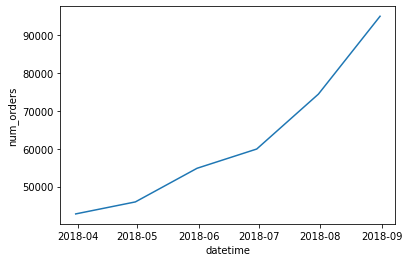

In [10]:
sns.lineplot(x = df_m.index, y = df_m['num_orders'] )

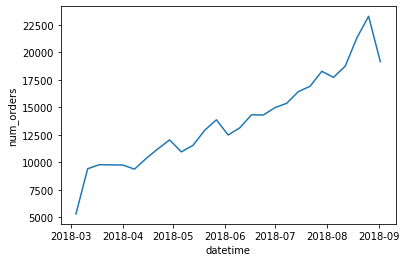

In [11]:
sns.lineplot(x = df_w.index, y = df_w['num_orders'] )

Кол-во заказов растет, посмотрим на скользящее среднее и скользящее стандартное отклонение

In [12]:
df_h['mean'] = df_h['num_orders'].rolling(25).mean()
df_h['std'] = df_h['num_orders'].rolling(25).std()

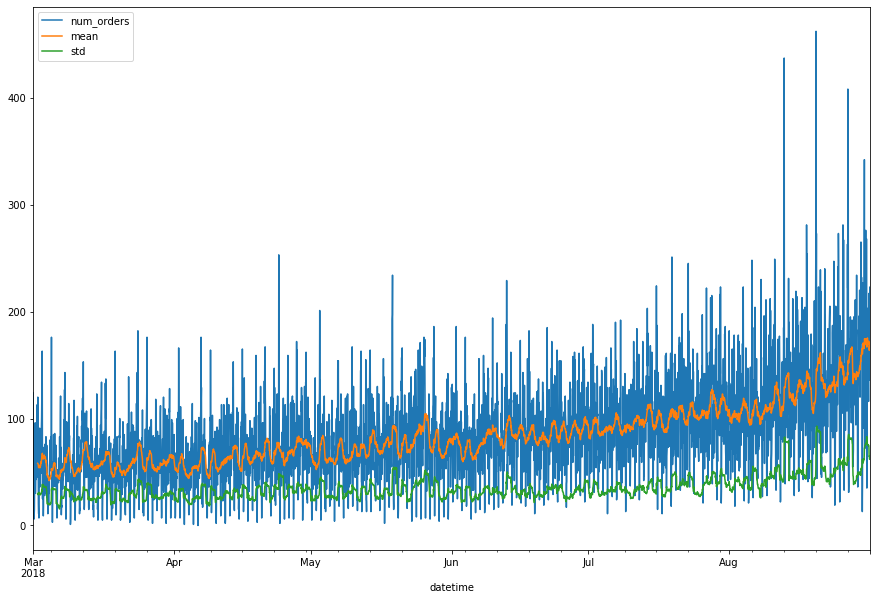

In [13]:
df_h.plot(figsize=(15, 10))

In [14]:
df_copy = df.copy()
df_copy = df_copy.resample('1H').sum()
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

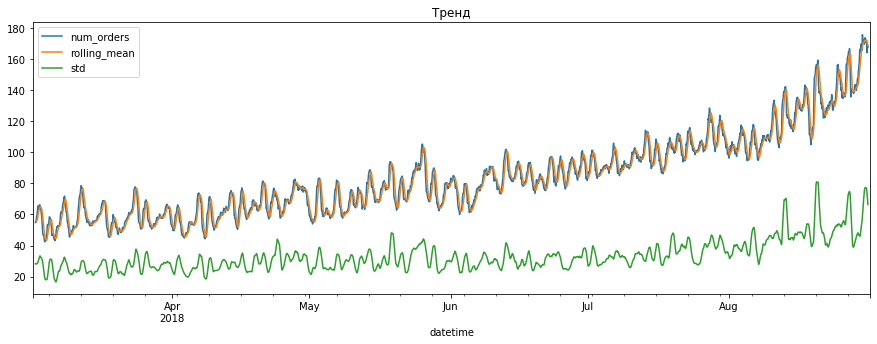

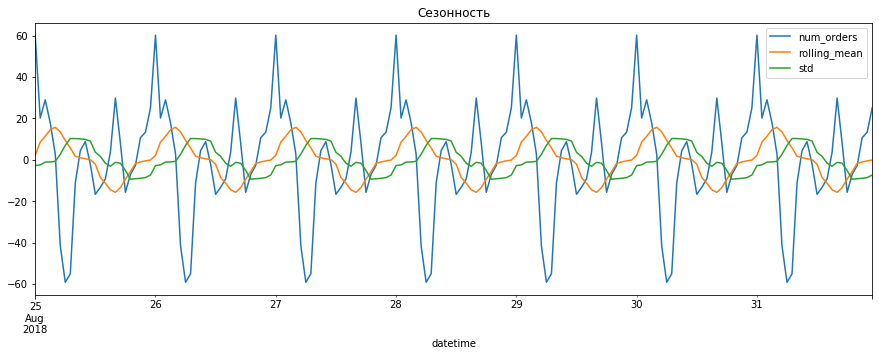

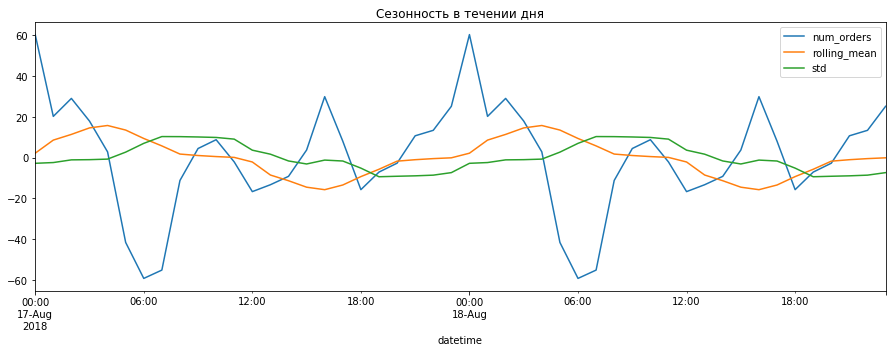

In [15]:
decomposed_df = seasonal_decompose(df_copy)
decomposed_df.trend.plot(title='Тренд', figsize=(15,5))
decomposed_df.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,5))
plt.figure(figsize=(15, 4))
decomposed_df.seasonal['2018-08-17':'2018-08-18'].plot(ax=plt.gca(), figsize=(12.5,5))
plt.title('Сезонность в течении дня')
plt.tight_layout()

### Вывод:
 - Кол-во заказов растет
 - На графиках сезонности все логично, в выходные ездять меньше чем в будни. В 6 утра провал, пик в 16 часов и в полночь, люди возвращаются домой.

## Обучение

In [166]:
def make_features(data, target_col,max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target_col].shift(lag)

    data['rolling_mean'] = data[target_col].shift().rolling(rolling_mean_size).mean()

In [167]:
df_reg = df.resample('1H').sum()

Сформируем признаки, нашей функцией

In [168]:
make_features(df_reg, 'num_orders', 2, 24)

Тут руками подбирал, мучает вопрос не много ли? Может тут стоило подобрать на линейной регрессии для скорости, а потом пробовать другие модели?

In [169]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
num_orders      4416 non-null int64
dayofweek       4416 non-null int64
hour            4416 non-null int64
lag_1           4415 non-null float64
lag_2           4414 non-null float64
rolling_mean    4392 non-null float64
dtypes: float64(3), int64(3)
memory usage: 241.5 KB


Разобъем выборку на тестовую и обучающую, в соотношении 1/10

In [170]:
train, test = train_test_split(df_reg, shuffle=False, test_size=0.1)
train = train.dropna()

In [171]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

### Линейная регрессия

Линейная регрессия, RMSE: 51.268666988640035


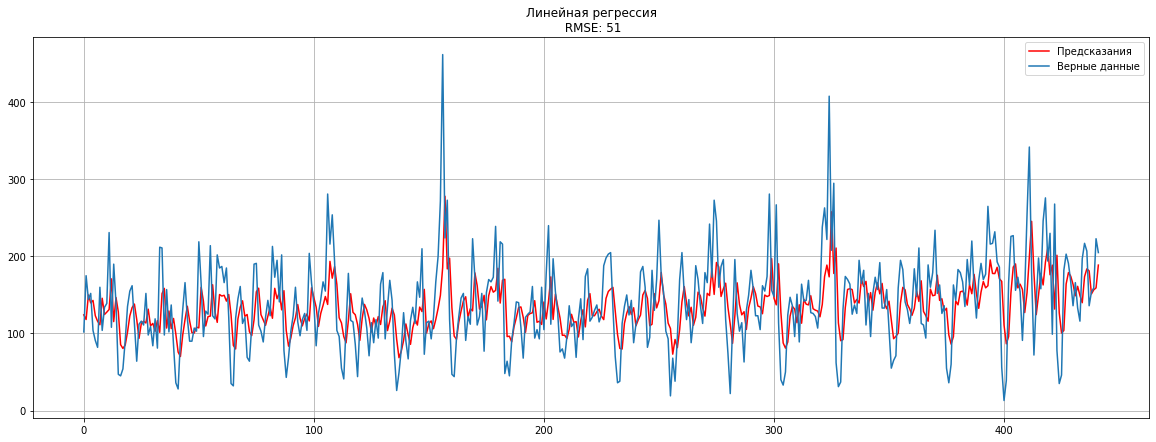

In [172]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_prediction = lr_model.predict(X_test)
plt.figure(figsize=(20, 7))
plt.plot(lr_prediction, "r", label="Предсказания")
plt.plot(y_test.values, label="Верные данные")
plt.legend(loc="best")
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_prediction))
plt.title("Линейная регрессия\n RMSE: {}".format(round(lr_rmse)))
plt.grid(True);
print('Линейная регрессия, RMSE:', lr_rmse) 

### LightGBM

[1]	valid_0's rmse: 76.3127	valid_0's l2: 5823.63
[2]	valid_0's rmse: 70.6149	valid_0's l2: 4986.46
[3]	valid_0's rmse: 66.1495	valid_0's l2: 4375.75
[4]	valid_0's rmse: 62.3894	valid_0's l2: 3892.43
[5]	valid_0's rmse: 60.1525	valid_0's l2: 3618.32
[6]	valid_0's rmse: 57.0238	valid_0's l2: 3251.72
[7]	valid_0's rmse: 54.88	valid_0's l2: 3011.82
[8]	valid_0's rmse: 53.4172	valid_0's l2: 2853.4
[9]	valid_0's rmse: 51.638	valid_0's l2: 2666.48
[10]	valid_0's rmse: 51.0324	valid_0's l2: 2604.31
[11]	valid_0's rmse: 49.9962	valid_0's l2: 2499.62
[12]	valid_0's rmse: 49.3516	valid_0's l2: 2435.58
[13]	valid_0's rmse: 48.4429	valid_0's l2: 2346.72
[14]	valid_0's rmse: 47.9233	valid_0's l2: 2296.64
[15]	valid_0's rmse: 46.973	valid_0's l2: 2206.47
[16]	valid_0's rmse: 46.4079	valid_0's l2: 2153.69
[17]	valid_0's rmse: 46.2976	valid_0's l2: 2143.47
[18]	valid_0's rmse: 45.627	valid_0's l2: 2081.83
[19]	valid_0's rmse: 45.3295	valid_0's l2: 2054.77
[20]	valid_0's rmse: 45.1718	valid_0's l2: 204

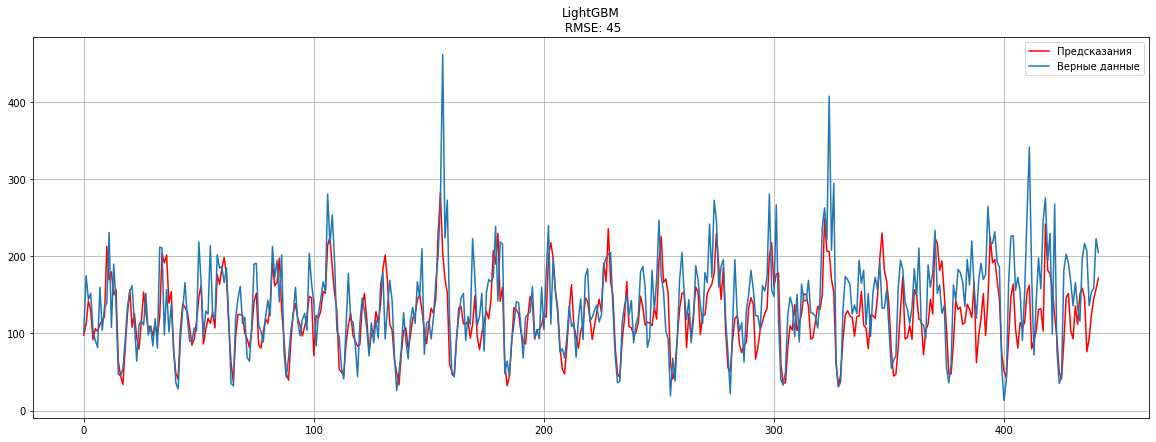

In [173]:
lgb_model = lgb.LGBMRegressor(learning_rate=0.2, verbose = 200)

lgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    eval_metric='rmse')

lgb_prediction = lgb_model.predict(X_test)
plt.figure(figsize=(20, 7))
plt.plot(lgb_prediction, "r", label="Предсказания")
plt.plot(y_test.values, label="Верные данные")
plt.legend(loc="best")
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_prediction))
plt.title("LightGBM\n RMSE: {}".format(round(lgb_rmse)))
plt.grid(True);
print('LightGBM, RMSE:', lgb_rmse) 

RMSE на линейной регрессии лучше. Попробуем подобрать гиперпараметры у LightGBM.

In [174]:
def objective(trial):
    params={'verbosity':-1,
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100, step=0.05),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.1, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pr = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pr))
    return rmse

study = optuna.create_study()
study.optimize(objective,n_trials=100, timeout=600)

[I 2022-01-30 13:30:25,673] A new study created in memory with name: no-name-780eb12c-bd48-476b-8834-facf936ef101
[I 2022-01-30 13:30:25,868] Trial 0 finished with value: 55.98676746253027 and parameters: {'lambda_l2': 0.49328073260077665, 'max_depth': 65, 'num_leaves': 5, 'learning_rate': 0.031, 'bagging_fraction': 0.7}. Best is trial 0 with value: 55.98676746253027.
[I 2022-01-30 13:30:28,568] Trial 1 finished with value: 45.362963672517246 and parameters: {'lambda_l2': 0.8739508617676894, 'max_depth': 67, 'num_leaves': 105, 'learning_rate': 0.041, 'bagging_fraction': 0.6}. Best is trial 1 with value: 45.362963672517246.
[I 2022-01-30 13:30:29,862] Trial 2 finished with value: 51.27397421109116 and parameters: {'lambda_l2': 0.3019063550045593, 'max_depth': 86, 'num_leaves': 35, 'learning_rate': 0.021, 'bagging_fraction': 0.5}. Best is trial 1 with value: 45.362963672517246.
[I 2022-01-30 13:30:30,070] Trial 3 finished with value: 68.62549865492215 and parameters: {'lambda_l2': 0.9301

In [175]:
print(study.best_params)
print(study.best_value)

{'lambda_l2': 0.2587072696200919, 'max_depth': 33, 'num_leaves': 25, 'learning_rate': 0.081, 'bagging_fraction': 0.8}
43.25146195977548


Не вышло...Линейная регрессия справилась быстрее и лучше чем lightGBM. 

## Тестирование

Проверим на адекватность

In [176]:
pred_median = np.ones(y_test.shape) * train['num_orders'].median()
med_rmse = np.sqrt(mean_squared_error(y_test,pred_median))
med_rmse

87.15277582981295

Наша модель прогнозирует лучше, чем медианные значения. Посмотрим feature importance у нашей модели.

In [177]:
#importance = lr_model.coef_
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))

Не разобрался как вывести имена фичей...

[1]	valid_0's rmse: 81.3872	valid_0's l2: 6623.88
[2]	valid_0's rmse: 78.4592	valid_0's l2: 6155.85
[3]	valid_0's rmse: 75.7674	valid_0's l2: 5740.69
[4]	valid_0's rmse: 73.6449	valid_0's l2: 5423.57
[5]	valid_0's rmse: 71.5476	valid_0's l2: 5119.06
[6]	valid_0's rmse: 69.9253	valid_0's l2: 4889.55
[7]	valid_0's rmse: 68.2571	valid_0's l2: 4659.03
[8]	valid_0's rmse: 66.7102	valid_0's l2: 4450.25
[9]	valid_0's rmse: 65.3154	valid_0's l2: 4266.1
[10]	valid_0's rmse: 64.0231	valid_0's l2: 4098.96
[11]	valid_0's rmse: 62.8988	valid_0's l2: 3956.26
[12]	valid_0's rmse: 61.3706	valid_0's l2: 3766.35
[13]	valid_0's rmse: 59.9804	valid_0's l2: 3597.64
[14]	valid_0's rmse: 59.1612	valid_0's l2: 3500.04
[15]	valid_0's rmse: 58.2996	valid_0's l2: 3398.84
[16]	valid_0's rmse: 57.5533	valid_0's l2: 3312.38
[17]	valid_0's rmse: 56.4048	valid_0's l2: 3181.51
[18]	valid_0's rmse: 55.7047	valid_0's l2: 3103.01
[19]	valid_0's rmse: 54.908	valid_0's l2: 3014.89
[20]	valid_0's rmse: 54.3773	valid_0's l2:

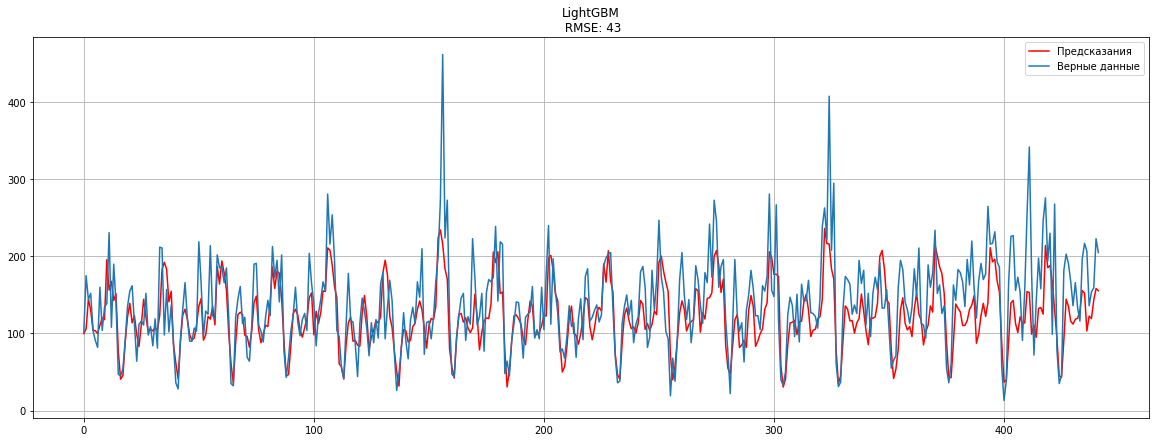

In [178]:
lgb_model = lgb.LGBMRegressor(lambda_l2 = 0.714347830694159, max_depth = 23, num_leaves = 25,
                                learning_rate = 0.081, bagging_fraction = 0.6) 
#lgb_model = lgb.LGBMRegressor(**study.best_params)

lgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    eval_metric='rmse')

lgb_prediction = lgb_model.predict(X_test)
plt.figure(figsize=(20, 7))
plt.plot(lgb_prediction, "r", label="Предсказания")
plt.plot(y_test.values, label="Верные данные")
plt.legend(loc="best")
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_prediction))
plt.title("LightGBM\n RMSE: {}".format(round(lgb_rmse)))
plt.grid(True);
print('LightGBM, RMSE:', lgb_rmse) 

Text(0, 0.5, 'Признаки')

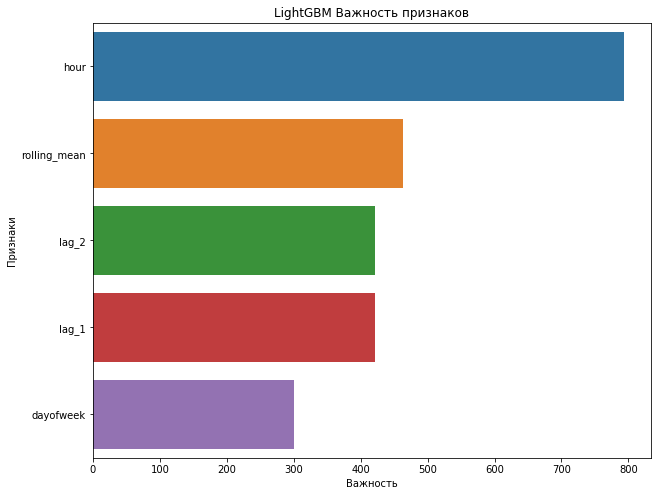

In [179]:
feature_importance = np.array(lgb_model.feature_importances_)
feature_names = np.array(X_test.columns)
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(10,8))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('LightGBM Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')

## Вывод:
 - LightGBM справился с задачей, удалось улучшить с помощью добора гиперпараметров. 
 - RMSE: 43
 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48